## Quantitative QC by CV calculation
The data used in this notebook is lymphocyte data for one patient's B cells and T cells. We use this data to show the proteome variation between the cell types. Here, we calculate CVs to show the quality of the data.

After calculating CVs, we calculate Spearman correlation among replicates.


First, we import our loader module. This brings the functions defined there (in our repository at ~/load_data.py) into scope so we can use them in this script. Then we can load our data and store it as <code>data</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [1]:
import load_data
data_raw = load_data.load_FragPipe(version="July_noMBR_FP", contains=[])

In [2]:
new_names={}
for c in data_raw.columns.values: 
    new_names[c] = c.split(' ')[0]
data_raw.rename(columns=new_names, inplace=True)
data_raw.head()

,Blank_3,Blank_4,Blank_5,Subject1_B_cells_062920_C_10,Subject1_B_cells_062920_C_11,Subject1_B_cells_062920_C_12,Subject1_B_cells_062920_C_13,Subject1_B_cells_062920_C_9,Subject1_B_cells_072920_C_4,Subject1_B_cells_072920_C_5,...,Subject2_T_cells_062920_F_12,Subject2_T_cells_062920_F_13,Subject2_T_cells_062920_F_14,Subject2_T_cells_062920_F_9,Subject2_T_cells_072920_F_1,Subject2_T_cells_072920_F_3,Subject2_T_cells_072920_F_4,Subject2_T_cells_072920_F_5,Subject2_T_cells_072920_F_6,Subject2_T_cells_072920_F_8
Protein ID,,,,,,,,,,,,,,,,,,,,,
A0A0B4J2D5,0.0,0.0,0.0,3203277.5,4697996.0,7346776.5,8472867.0,4280919.5,0.0,4787781.50,...,0.0,4905873.00,0.0,3405266.0,4656720.00,1673629.9,6060600.5,2407679.5,7791855.0,5542659.50
A0AVT1,0.0,0.0,0.0,1917388.2,3033529.2,3773018.8,1865758.6,5191332.5,3332031.5,2464089.00,...,1091121.4,630647.25,576871.9,0.0,0.00,0.0,0.0,827356.1,1260652.0,0.00
A0FGR8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,1514363.4,866311.94,0.0,0.0,0.00,0.0,0.0,0.0,653698.6,879074.56
A6NHR9,0.0,0.0,0.0,2650513.5,0.0,3788095.8,0.0,0.0,1845555.5,933499.44,...,0.0,0.00,0.0,0.0,430484.97,0.0,0.0,0.0,538303.6,948190.40
A8K2U0,0.0,0.0,0.0,0.0,0.0,0.0,1149867.8,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00


Now we normalize across runs. Note that following median normalization, we reverse the log2, leaving the data aligned between runs but allowing the most typical coefficient variation calculation.

In [3]:
from numpy import nan
from numpy import log2
from statistics import median

data_log2 = log2(data_raw.replace(0,nan))
#global_median = median(data_log2.apply(lambda series: median(series.dropna())))


Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [4]:
import data_utils    
sets=['_B_cells','_T_cells',
      'Subject1','Subject2','062920','072920',"_"]
cell_types = ['_B', '_T']
indecies = data_log2.apply(data_utils.check_n_of_each_type, axis=1,
                      cell_types = cell_types)
data_filtered = data_log2[indecies]
#data.head()

In [5]:
data_log2_normalized = data_filtered.apply(lambda series: series-median(series.dropna()))#+global_median)
data = data_log2_normalized.apply(lambda series: 2**series)

Finally, we will calculate the coeffients of variation for each protein within each of the two cell types. 

In [6]:
from scipy.stats import variation
from statistics import mean
import pandas as pd
from numpy import isnan

In [7]:
CVs = {}
for population in sets:
    cells_in_population = list(s for s in data.columns.values.tolist() if population in s)
    data_by_type = data[cells_in_population]
    #now we have a dataframe with just one subpopulation
    #Call variation function
    var = data_by_type.apply(variation, axis=1, nan_policy='omit')
    CVs[population] = var
    
    #Here we report an overview
    print (population)
    print ('Mean CV:\t',mean(var))
    print ('Min CV: \t',min(var))
    print ('Max CV: \t',max(var))
    print ('nan:    \t',len([i for i in var if isnan(i)]))
    print ('Zero:    \t',len([i for i in var if i==0]))
    var_under_20 = len([i for i in var if i < .2])
    var_under_10 = len([i for i in var if i < .1])
    count = len(var)#len([i for i in var if i!=0])
    print ('Under 10%:\t',var_under_10,'\t{0:.2f}'.format(var_under_10/count))
    print ('Under 20%:\t',var_under_20,'\t{0:.2f}'.format(var_under_20/count))
    print (count)
    print ()
    

CVs = pd.DataFrame.from_dict(CVs)    

_B_cells
Mean CV:	 0.41406573695585897
Min CV: 	 0.09065343630991682
Max CV: 	 2.673621345967577
nan:    	 0
Zero:    	 0
Under 10%:	 1 	0.00
Under 20%:	 114 	0.07
1556

_T_cells
Mean CV:	 0.3803438191228883
Min CV: 	 0.02798889714379712
Max CV: 	 2.1360955337905305
nan:    	 0
Zero:    	 0
Under 10%:	 9 	0.01
Under 20%:	 283 	0.18
1556

Subject1
Mean CV:	 0.4016260048860532
Min CV: 	 0.0
Max CV: 	 2.875453608365244
nan:    	 0
Zero:    	 8
Under 10%:	 18 	0.01
Under 20%:	 212 	0.14
1556

Subject2
Mean CV:	 0.408930045114932
Min CV: 	 0.0
Max CV: 	 2.4633009910479253
nan:    	 0
Zero:    	 6
Under 10%:	 7 	0.00
Under 20%:	 106 	0.07
1556

062920
Mean CV:	 0.3953243061549928
Min CV: 	 0.0
Max CV: 	 2.5132166422518667
nan:    	 0
Zero:    	 59
Under 10%:	 68 	0.04
Under 20%:	 252 	0.16
1556

072920
Mean CV:	 0.37957951820695934
Min CV: 	 0.0
Max CV: 	 3.2448590105500297
nan:    	 0
Zero:    	 6
Under 10%:	 10 	0.01
Under 20%:	 267 	0.17
1556

_
Mean CV:	 0.4857729367051879
Min CV: 	 0.14

Next, we will visualize the data, which shows that the majority of proteins have small coefficients of variation.

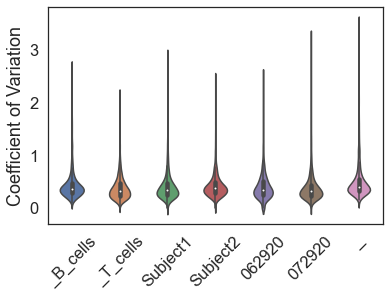

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
figure = sns.violinplot(data=CVs, width=.5)
figure.set_ylabel("Coefficient of Variation")
figure.set_xticklabels(sets, rotation=45)
#plt.savefig("CV_FP.png", dpi=300)

plt.show()

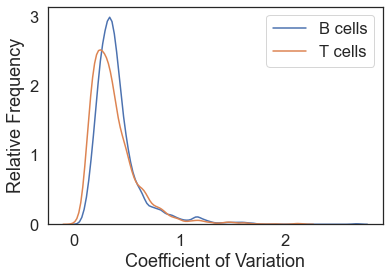

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)

sns.set_style("white")
figure = sns.distplot(CVs['_B_cells'], hist = False, label='B cells')#, width=.5)
figure = sns.distplot(CVs['_T_cells'], hist = False, label='T cells')#, width=.5)
figure.set_ylabel("Relative Frequency")
figure.set_xlabel("Coefficient of Variation")

figure.legend(['B cells', 'T cells'])
plt.show()

Here we summarize the CVs overall. Note that the CVs were calculated within types and so still represent technical variability, not variation between cell types.

In [10]:
var = CVs.values.flatten()

print ('Mean CV:\t',mean(var))
print ('Min CV: \t',min(var))
print ('Max CV: \t',max(var))
print ('nan:    \t',len([i for i in var if isnan(i)]))
print ('Zero:    \t',len([i for i in var if i==0]))
    
var_under_20 = len([i for i in var if i < .2])
var_under_10 = len([i for i in var if i < .1])
count = len(var)#len([i for i in var if i!=0])
print ('Under 10%:\t',var_under_10,'\t{0:.2f}'.format(var_under_10/count))
print ('Under 20%:\t',var_under_20,'\t{0:.2f}'.format(var_under_20/count))

Mean CV:	 0.40937748102098176
Min CV: 	 0.0
Max CV: 	 3.493676482964643
nan:    	 0
Zero:    	 79
Under 10%:	 113 	0.01
Under 20%:	 1249 	0.11


This shows accuracy in repeatedly characterizing each cell type.

### Correlation coefficient
Next, we show reproducibility of the replicates by Spearman correlation coefficient.

In [11]:
try: 
    data.drop(columns=['Blank_5','Blank_4','Blank_3'], inplace=True)
except: print()

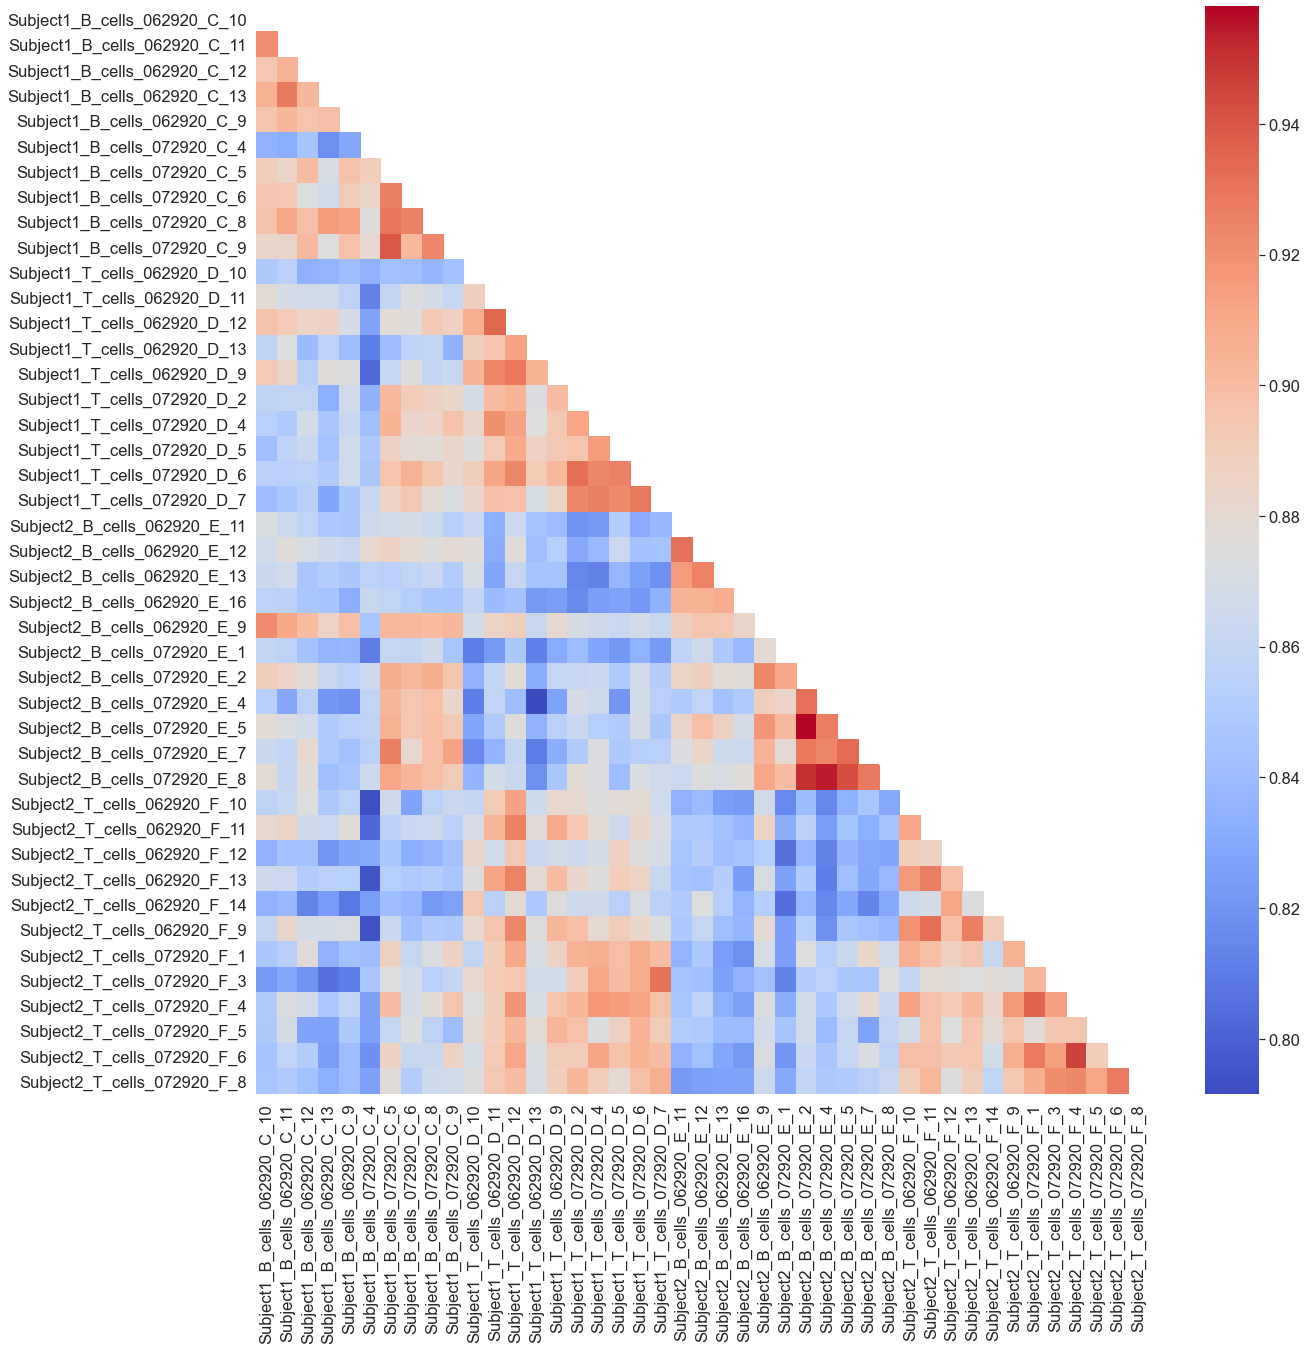

In [12]:
correlations = data.corr(method="spearman")

#labels=['B cells - C10','B cells - C11',
#                    'B cells - C12','B cells - C13',
#                    'B cells - C9  ','T cells - D10',
#                    'T cells - D11','T cells - D12',
#                    'T cells - D13','T cells - D9  ']

#correlations.index=labels
#correlations.columns=labels

import numpy as np
mask = np.zeros(correlations.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

fig = plt.figure(figsize=(20,20))
sns.heatmap(correlations, cmap = 'coolwarm', mask = mask) #annot=True


#plt.yticks(rotation=45) 
#plt.xticks(rotation=45)


#plt.savefig("data/FP_figures/correlations_heatmap_all_noMBR_FP.png", dpi=300,
#            bbox_inches='tight')

In [13]:
all_cell_types = ["Subject1_B_cells_062920","Subject1_B_cells_072920", "Subject2_B_cells_062920",  "Subject2_B_cells_072920",
              "Subject1_T_cells_062920","Subject1_T_cells_072920","Subject2_T_cells_062920", "Subject2_T_cells_072920"]

corr_summary = {}
for i in all_cell_types:
    corr_summary[i] = {}
    for j in all_cell_types:
        subset = list(s for s in correlations.columns if i in s)
        subset2 = list(s for s in correlations.columns if j in s)

        d = correlations[subset].loc[subset2]
        means = d.apply(lambda r: mean(r.dropna()))
        m = mean(means)
        corr_summary[i][j] = m
    
corr_summary = pd.DataFrame(corr_summary)


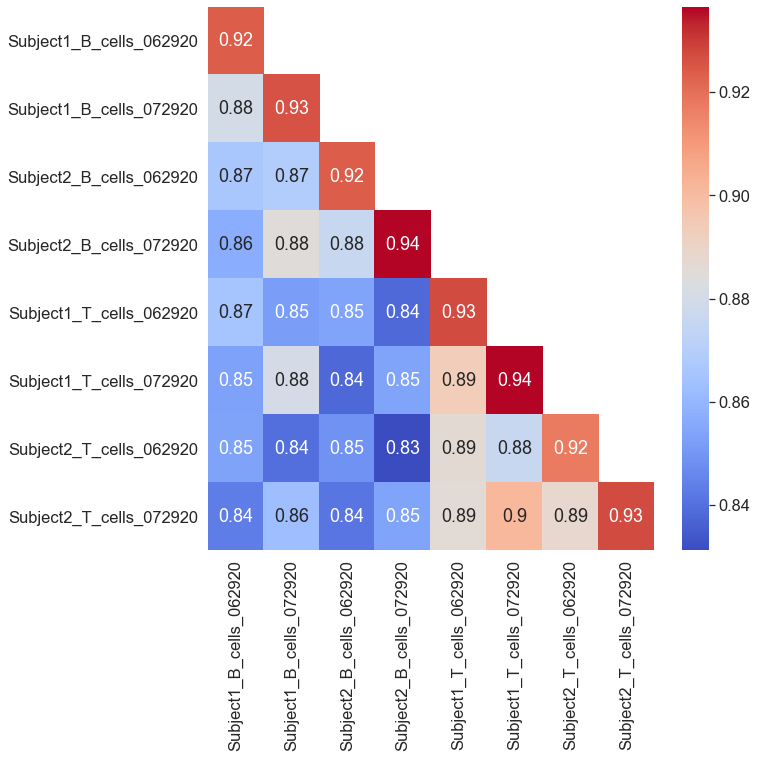

In [14]:
fig = plt.figure(figsize=(10,10))
mask = np.zeros(corr_summary.shape, dtype=bool)

mask[np.triu_indices(len(mask))] = True

for i in range(0,len(mask)):
    mask[i][i]=False
        
sns.heatmap(corr_summary, cmap = 'coolwarm', mask = mask, annot=True)

plt.savefig("data/correlations.png", dpi=300, bbox_inches='tight')

In [15]:
technical_corr = {}
for i in corr_summary:
     technical_corr[i] = corr_summary[i][i]

B = []
T = []
for i in technical_corr:
    if "B_cells" in i:
        B.append(technical_corr[i])
    if "T_cells" in i:
        T.append(technical_corr[i])
print( "Technical variability of B cells: ",mean(B))
print("Technical variability of T cells: ", mean(T))
mean(technical_corr.values())

Technical variability of B cells:  0.9276255490789896
Technical variability of T cells:  0.9270473748497734


0.9273364619643816

Here we split the dataset by cell type and perform the same correlation test. We then take the average correlation between replicates.

In [16]:
corr_type = {}
for cell_type in ["B_cells","T_cells"]:
    
    blocks_of_type = list(s for s in corr_summary.keys() if cell_type in s)
    
    corr_by_type = corr_summary[blocks_of_type]
    corr_by_type = corr_by_type.loc[blocks_of_type]
    
    #drop technical replicates
    for sample in corr_by_type.columns:
        corr_by_type[sample][sample]=nan
        
    #display(corr_by_type)
    
    corr_type[cell_type] = corr_by_type
    
    #take the average of the correlations between a sample and  
    #    the other samples of the same type
    summary = corr_by_type.apply(lambda x: mean(x.dropna()))
    
    print (cell_type,"average correlation:\t",mean(summary))
    """#"""

B_cells average correlation:	 0.8721728723434803
T_cells average correlation:	 0.888584050579865


In [17]:
B_type

NameError: name 'B_type' is not defined

In [ ]:
B_type = list(s for s in corr_summary.keys() if "B_cells" in s)
T_type = list(s for s in corr_summary.keys() if "T_cells" in s)
    
corr_by_type = corr_summary.loc[B_type, T_type]
    
corr_type[cell_type] = corr_by_type
    
#take the average of the correlations between a sample and  
#    the other samples of the same type
summary = corr_by_type.apply(lambda x: mean(x.dropna()))
    
print ("Average Cross-type correlation:\t",mean(summary))